In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

## Lectura de datos

El primer paso después de importar las librerías es leer la base de datos que dejamos preparada en el submódulo 1.6. 

In [3]:
df = pd.read_csv('df_model.csv')
target = 'est_socio'

In [4]:
df.head()

,tipo_viv,mat_pared,mat_techos,mat_pisos,cocina,num_cuarto,disp_agua,excusado,combustible,regadera,...,conex_inte,num_auto,gasto_tri,ing_tri,atemed,alfabetism,trabajo_mp,Escasez de alimentos,Tipo de comunidad,est_socio
0,Departamento en edificio,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,"Madera, mosaico u otro recubrimiento",Sí,2.00,Agua entubada dentro de la vivienda,Sí,Gas de tanque,Sí,...,Sí,0.00,22693.22,16229.49,0.666667,1.00,0.333333,Sí,Urbano,Medio alto
1,Casa independiente,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,"Madera, mosaico u otro recubrimiento",Sí,1.25,Agua entubada dentro de la vivienda,Sí,Gas natural o de tubería,Sí,...,Sí,0.25,18931.42,23827.86,0.500000,0.75,0.250000,Sí,Urbano,Medio alto
2,Casa independiente,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,"Madera, mosaico u otro recubrimiento",Sí,1.50,Agua entubada dentro de la vivienda,Sí,Gas de tanque,Sí,...,Sí,0.50,44520.13,37421.77,0.500000,1.00,1.000000,No,Urbano,Medio alto
3,Casa independiente,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,"Madera, mosaico u otro recubrimiento",Sí,2.50,Agua entubada dentro de la vivienda,Sí,Gas de tanque,Sí,...,Sí,0.00,76500.43,71557.37,0.500000,0.50,0.500000,No,Urbano,Medio alto
4,Casa independiente,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,"Madera, mosaico u otro recubrimiento",Sí,2.00,Agua entubada dentro de la vivienda,Sí,Gas de tanque,Sí,...,Sí,0.50,30140.68,71803.26,1.000000,1.00,0.500000,No,Urbano,Medio alto


## Procesamiento variables categóricas (encoding)

La implementación de *scikit-learn* no admite variables categóricas aún en los algoritmos que teóricamente podrían manejarlas. En nuestra base de datos tenemos varias variables categóricas, para resolver este problema utilizaremos la técnica de [One-Hot-Encoding](https://www.brutalk.com/es/noticias/brutalk-blog/ver/por-que-one-hot-encode-data-en-machine-learning-60471b11bb4df). Para ello utilizamos primero la función **Label Encoder**, para hacer una codificación con enteros (donde a cada categoría se le asigna un entero) y luego cada una de estas categorías pasará a ser una columna de la base de datos cuyos campos son binarios (1 si la persona en el índice correspondiente está en esa categoría y 0 si no), con la función **OneHotEncoder**. Previo a todo esto utilizamos el atributo de pandas **select_dtypes** para reconocer las variables categóricas y numéricas. Por último guardamos las variables categóricas ya procesadas en un nuevo dataframe que llamaremos "enc_df".

In [5]:
X = df.drop(columns=target) # Features
y = df[target] # Target variable

numerical = X.select_dtypes(include=np.number)
categorical = X.select_dtypes(exclude=np.number)

X_lenc = X.copy() 
dict_list = {}

labelencoder = LabelEncoder() # creating instance of labelencoder
for col in categorical:
    X_lenc[col] = labelencoder.fit_transform(X_lenc[col])
    dict_list[col] = dict(zip(X_lenc[col],X[col]))

# creating instance of one-hot-encoder
enc = OneHotEncoder()
enc_df = pd.DataFrame()
for col in categorical:
    temp = pd.DataFrame(enc.fit_transform(X_lenc[[col]]).toarray())
    temp.rename(columns=dict(zip(list(range(len(temp.columns))),[str(col)+'_'+str(dict_list[col][i]) for i in list(range(len(temp.columns)))])),inplace=True)
    enc_df = pd.concat([enc_df,temp],axis=1)

In [6]:
enc_df

,tipo_viv_Casa independiente,tipo_viv_Departamento en edificio,tipo_viv_Local no construido para habitación,tipo_viv_Vivienda en cuarto de azotea,tipo_viv_Vivienda en vecindad,mat_pared_Adobe,mat_pared_Carrizo bambú o palma,mat_pared_Embarro o bajareque,mat_pared_Lámina de asbesto o metálica,mat_pared_Lámina de cartón,...,tinaco_azo_No,tinaco_azo_Sí,celular_No,celular_Sí,conex_inte_No,conex_inte_Sí,Escasez de alimentos_No,Escasez de alimentos_Sí,Tipo de comunidad_Rural,Tipo de comunidad_Urbano
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88064,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
88065,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
88066,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
88067,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


## Procesamiento variables continuas (escalamiento)

Las variables continuas pueden tener una escala muy diferente, lo cual puede afectar la precisión y eficacia del modelo, por lo que aplicaremos el escalamiento que vimos previamente. Seguidamente agregamos las variables continuas a "enc_df".

In [7]:
scale= StandardScaler()
scaled_numerical = scale.fit_transform(numerical)
numerical = pd.DataFrame(scaled_numerical,columns=numerical.columns)

In [8]:
enc_df = pd.concat([enc_df,numerical], axis=1)

In [9]:
print(enc_df.columns,'\n')

Index(['tipo_viv_Casa independiente', 'tipo_viv_Departamento en edificio',
       'tipo_viv_Local no construido para habitación',
       'tipo_viv_Vivienda en cuarto de azotea',
       'tipo_viv_Vivienda en vecindad', 'mat_pared_Adobe',
       'mat_pared_Carrizo bambú o palma', 'mat_pared_Embarro o bajareque',
       'mat_pared_Lámina de asbesto o metálica', 'mat_pared_Lámina de cartón',
       'mat_pared_Madera', 'mat_pared_Material de desecho',
       'mat_pared_Tabique, ladrillo, block, piedra, cantera, cemento o concreto',
       'mat_techos_Losa de concreto o viguetas con bovedilla',
       'mat_techos_Lámina de asbesto', 'mat_techos_Lámina de cartón',
       'mat_techos_Lámina de fibrocemento ondulada (techo fijo)',
       'mat_techos_Lámina metálica', 'mat_techos_Madera o tejamanil',
       'mat_techos_Material de desecho', 'mat_techos_Palma o paja',
       'mat_techos_Teja', 'mat_techos_Terrado con viguería',
       'mat_pisos_Cemento o firme',
       'mat_pisos_Madera, mosaico

## Modelos

A continuación utilizaremos la implementación de *scikit-learn* de los modelos de clasificación que vimos anterioremente para predecir la variable objetivo y compararemos su precisión con la métrica que también vimos en la presentación.

### Regresión Logística 

El primer modelo que utilizaremos es la [regresión logística], usualmente este método predice variables objetivo binarias, sin embargo existe una versión [multinomial](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) que permite predecir variables objetivo categóricas, con más de dos valores posibles. Implementaremos ambas de la siguiente forma. 
Nuestra variable objetivo tiene cuatro valores, 'Alto', 'Medio alto', 'Medio bajo' y 'Bajo'. Para la implementación de la regresión logística usual haremos esta variable binaria tomando los valores alto y medio alto como 1 y los valores bajo y medio bajo como 0. Y para la implementación de la regresión logística multinomial reemplazaremos 'Alto', 'Medio alto', 'Medio bajo' y 'Bajo' por 3,2,1 y 0 respectivamente.    

In [10]:
y = df[target]
y_bin = y.replace(['Medio alto','Medio bajo','Bajo','Alto'],[1,0,0,1])
X = enc_df.copy()
X.fillna(0,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=1)

log = LogisticRegression()
log = log.fit(X_train,y_train)
log_pred = log.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, log_pred))

Accuracy: 0.8377427046667424


In [11]:
y = df[target]
y = y.replace(['Medio alto','Medio bajo','Bajo','Alto'],[2,1,0,3])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
log_multi = LogisticRegression(multi_class='multinomial')
log_multi = log_multi.fit(X_train,y_train)
log_multi_pred = log_multi.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, log_multi_pred))

Accuracy: 0.673479429241891


### Decision trees 

A continuación veamos cómo funciona el entrenamiento de los árboles de decisión y bosques aleatorios

In [12]:
dct = tree.DecisionTreeClassifier()
dct = dct.fit(X_train, y_train)
dct_pred = dct.predict((X_test))
print("Accuracy:",metrics.accuracy_score(y_test, dct_pred))

Accuracy: 0.5663676620869763


### Random Forest

In [13]:
rfc = RandomForestClassifier().fit(X_train,y_train)
rfc_pred =  rfc.predict(X_test) 
print("Accuracy:",metrics.accuracy_score(y_test, rfc_pred))

Accuracy: 0.6605730290299383


In [14]:
text_representation = tree.export_text(dct)
print(text_representation)

|--- feature_55 <= 0.50
|   |--- feature_24 <= 0.50
|   |   |--- feature_41 <= 0.50
|   |   |   |--- feature_46 <= 0.50
|   |   |   |   |--- feature_31 <= 0.50
|   |   |   |   |   |--- feature_32 <= 0.50
|   |   |   |   |   |   |--- feature_33 <= 0.50
|   |   |   |   |   |   |   |--- feature_58 <= 0.98
|   |   |   |   |   |   |   |   |--- feature_63 <= 0.29
|   |   |   |   |   |   |   |   |   |--- feature_63 <= 0.03
|   |   |   |   |   |   |   |   |   |   |--- feature_10 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |   |   |   |   |   |   |--- feature_10 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |--- feature_63 >  0.03
|   |   |   |   |   |   |   |   |   |   |--- feature_10 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- feature_10 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- tr

In [15]:
# Descomentar para ver visualización


# import graphviz
# # DOT data
# dot_data = tree.export_graphviz(dct, out_file=None, 
#                                 feature_names=X_train.columns,  
#                                 class_names=y_train.name,
#                                 filled=True)

# # Draw graph
# graph = graphviz.Source(dot_data, format="png") 
# graph

## Resultados e interpretación  

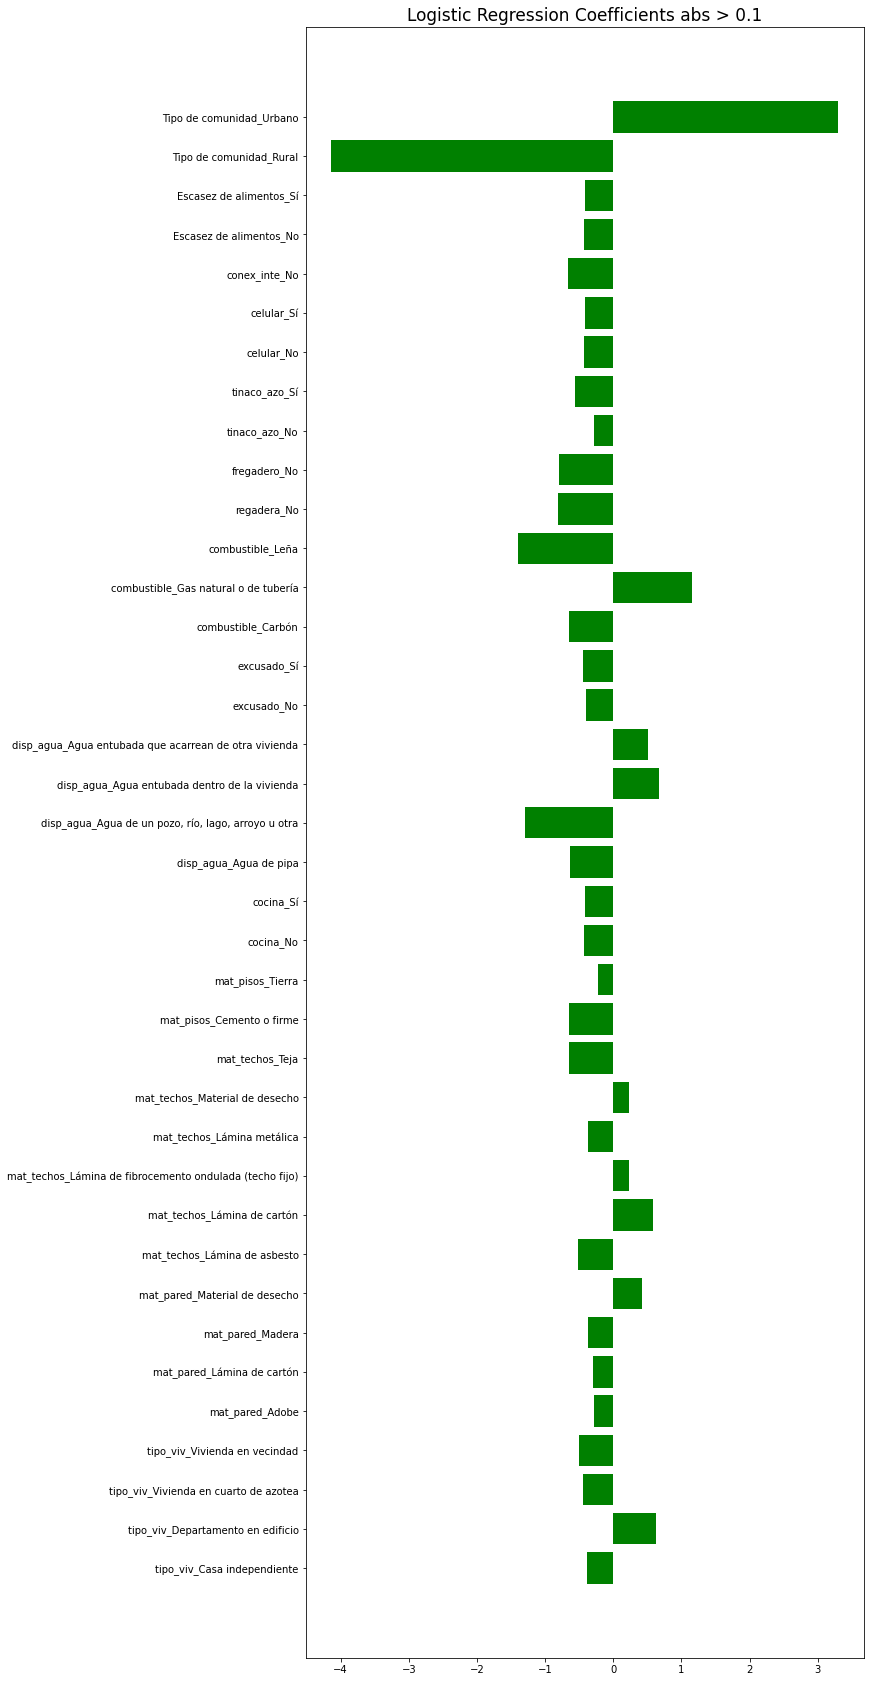

In [16]:
log_importance = log.coef_.flatten()
log_importance = pd.DataFrame({'Variable':X_train.columns,'Log_coeff':log_importance})
log_importance = log_importance[abs(log_importance['Log_coeff'])>0.2]
plt.rcParams['figure.figsize']=(10,30)
plt.barh('Variable','Log_coeff',data=log_importance,color='g')
plt.title('Logistic Regression Coefficients abs > 0.1',fontsize=17)
plt.show()

In [17]:
log_importance

,Variable,Log_coeff
0,tipo_viv_Casa independiente,-0.382491
1,tipo_viv_Departamento en edificio,0.629358
3,tipo_viv_Vivienda en cuarto de azotea,-0.442557
4,tipo_viv_Vivienda en vecindad,-0.503583
5,mat_pared_Adobe,-0.283287
9,mat_pared_Lámina de cartón,-0.300406
10,mat_pared_Madera,-0.377047
11,mat_pared_Material de desecho,0.429026
14,mat_techos_Lámina de asbesto,-0.520142
15,mat_techos_Lámina de cartón,0.588308


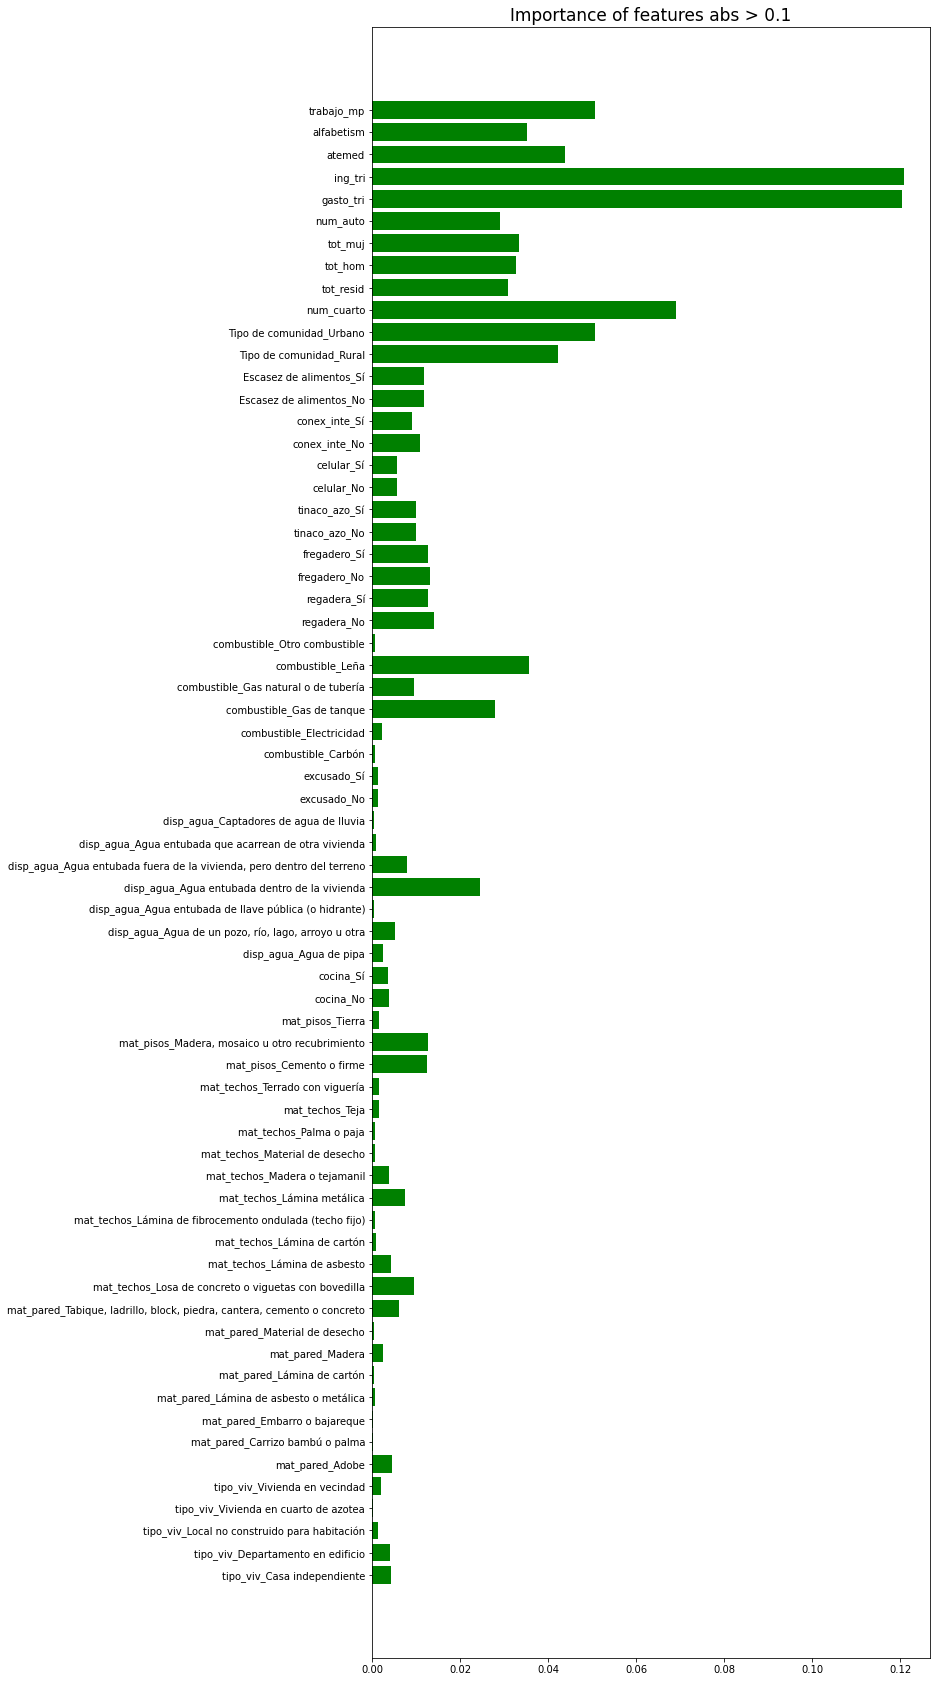

In [18]:
rfc_importance = rfc.feature_importances_
rfc_importance = pd.DataFrame({'Variable':X_train.columns,'Importance':rfc_importance})
plt.rcParams['figure.figsize']=(10,30)
plt.barh('Variable','Importance',data=rfc_importance,color='g')
plt.title('Importance of features abs > 0.1',fontsize=17)
plt.show()

In [19]:
imp = rfc_importance  
dic = {}
for column in X.columns:
    dic[column] = 0
    for col in imp['Variable']:
        if column in col:
            dic[column] += imp.loc[imp[imp['Variable']==col].index,'Importance'].values * enc_df[col].value_counts()[1]/len(enc_df.index)*100

total_importance = pd.DataFrame(dic).transpose().reset_index().rename(columns={'index':'Variable',0:'Importance'})            
total_importance = total_importance.sort_values(by=['Importance'],ascending=True)
total_importance = round(total_importance,4)                 
total_importance

KeyError: 1

In [ ]:
enc_df[enc_df.columns[0]].value_counts()